# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import gzip
import json
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, FunctionTransformer
import os
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
import warnings
from lightgbm import LGBMClassifier
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from tqdm import tqdm, trange

# nltk imports:

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itsmm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

## Step 1: Load data

In [2]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the training directory
training_dir = os.path.join(data_dir, 'training')

# File path for 'train-classification.csv'
train_classification_path = os.path.join(training_dir, 'train-classification.csv')

# Step 2: Load Data Dynamically
train_classification_df = pd.read_csv(train_classification_path)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Step 3: Unify Labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)

# Step 4: Create User-to-Category Mapping
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

# Step 5: Verify Output
print("First few rows of the training classification DataFrame:")
train_classification_df.head()

First few rows of the training classification DataFrame:


,user_id,category
0,taskirancemal,mom and children
1,tam_kararinda,food
2,spart4nn,food
3,sosyalyiyiciler,food
4,sonaydizdarahad,mom and children


In [3]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the training directory
training_dir = os.path.join(data_dir, 'training')

# File path for 'training-dataset.jsonl.gz'
train_data_path = os.path.join(training_dir, 'training-dataset.jsonl.gz')

# Step 2: Initialize Dictionaries for Data
username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()

# Step 3: Process Data from 'training-dataset.jsonl.gz'
with gzip.open(train_data_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        sample = json.loads(line)

        profile = sample["profile"]
        username = profile.get("username", "").strip()  # Handle missing or empty usernames
        if not username:
            continue  # Skip if username is missing or empty

        if username in username2_category:
            # Train data info
            username2posts_train[username] = sample["posts"]
            username2profile_train[username] = profile
        else:
            # Test data info
            username2posts_test[username] = sample["posts"]
            username2profile_test[username] = profile

# Step 4: Verify Output
print(f"Number of Training Users: {len(username2posts_train)}")
print(f"Number of Testing Users: {len(username2posts_test)}")

Number of Training Users: 2741
Number of Testing Users: 2674


In [4]:
# Label statistics

train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [5]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(1)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [6]:
# Step 5: Verify Output
print("Columns in train_classification_df:")
print(train_classification_df.columns.tolist())

print("\nFirst few rows of the training classification DataFrame:")
print(train_classification_df.head())

print("\nLabel distribution:")
print(train_classification_df['category'].value_counts())

Columns in train_classification_df:
['user_id', 'category']

First few rows of the training classification DataFrame:
           user_id          category
0    taskirancemal  mom and children
1    tam_kararinda              food
2         spart4nn              food
3  sosyalyiyiciler              food
4  sonaydizdarahad  mom and children

Label distribution:
category
food                    511
health and lifestyle    503
tech                    346
entertainment           323
fashion                 299
travel                  294
art                     191
mom and children        149
sports                  113
gaming                   13
Name: count, dtype: int64


In [7]:
# Profile Dataframe
print("Columns in train_profile_df:")
print(train_profile_df.columns.tolist())

print("\nFirst few rows of train_profile_df:")
print(train_profile_df.head(1))

print("\nColumns in test_profile_df:")
print(test_profile_df.columns.tolist())

print("\nFirst few rows of test_profile_df:")
print(test_profile_df.head(1))

# Create username to category mapping dictionary
username2category = dict(zip(train_classification_df['user_id'], train_classification_df['category']))

print("First few entries in the username2category dictionary:")
list(username2category.items())[:2]

Columns in train_profile_df:
['username', 'id', 'full_name', 'biography', 'category_name', 'post_count', 'follower_count', 'following_count', 'is_business_account', 'is_private', 'is_verified', 'highlight_reel_count', 'bio_links', 'entities', 'ai_agent_type', 'fb_profile_biolink', 'restricted_by_viewer', 'country_block', 'eimu_id', 'external_url', 'fbid', 'has_clips', 'hide_like_and_view_counts', 'is_professional_account', 'is_supervision_enabled', 'is_guardian_of_viewer', 'is_supervised_by_viewer', 'is_supervised_user', 'is_embeds_disabled', 'is_joined_recently', 'business_address_json', 'business_contact_method', 'business_email', 'business_phone_number', 'business_category_name', 'overall_category_name', 'category_enum', 'is_verified_by_mv4b', 'is_regulated_c18', 'profile_pic_url', 'should_show_category', 'should_show_public_contacts', 'show_account_transparency_details', 'profile_picture_base64']

First few rows of train_profile_df:
     username          id    full_name  \
0  depa

[('taskirancemal', 'mom and children'), ('tam_kararinda', 'food')]

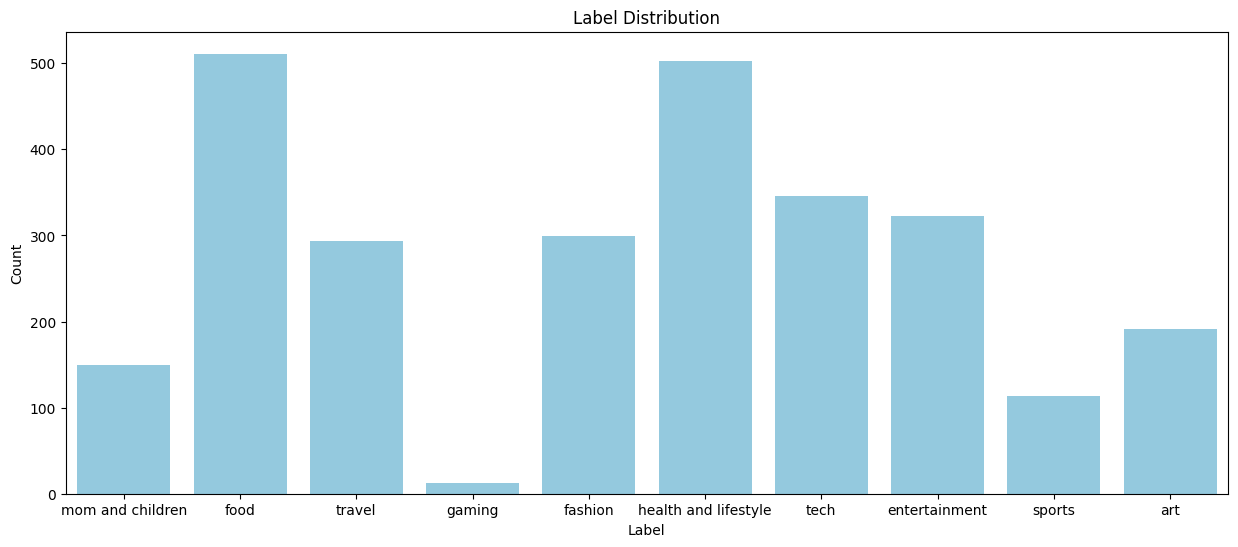

In [8]:
# Plot distribution of labels

plt.figure(figsize=(15, 6))
sns.countplot(data=train_classification_df, x='category', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
# Missing values

print("Missing values in train_profile_df:")
print(train_profile_df.isnull().sum())

Missing values in train_profile_df:
username                                0
id                                      0
full_name                              26
biography                             170
category_name                         515
post_count                           2466
follower_count                          0
following_count                         0
is_business_account                     0
is_private                              0
is_verified                             0
highlight_reel_count                    0
bio_links                               0
entities                              170
ai_agent_type                        2741
fb_profile_biolink                   2741
restricted_by_viewer                 2741
country_block                           0
eimu_id                                 0
external_url                          457
fbid                                    0
has_clips                               0
hide_like_and_view_counts               

In [10]:
# Drop unnecessary columns

# List of columns to drop
columns_to_drop = [
    'entities', 'ai_agent_type', 'fb_profile_biolink',
    'restricted_by_viewer', 'country_block', 'eimu_id', 'external_url', 'fbid',
    'hide_like_and_view_counts', 'is_supervision_enabled',
    'is_guardian_of_viewer', 'is_supervised_by_viewer', 'is_supervised_user',
    'is_embeds_disabled', 'business_address_json',
    'business_contact_method', 'business_email', 'business_phone_number',
    'category_enum', 'is_verified_by_mv4b', 'is_regulated_c18',
    'profile_pic_url', 'should_show_category', 'should_show_public_contacts',
    'show_account_transparency_details', 'profile_picture_base64'
]
# Dropping specified columns from train_profile_df
train_profile_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Dropping specified columns from test_profile_df
test_profile_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Verify columns in train_profile_df after dropping
print("Columns in train_profile_df after dropping:")
print(train_profile_df.columns.tolist())

# Verify columns in test_profile_df after dropping
print("\nColumns in test_profile_df after dropping:")
print(test_profile_df.columns.tolist())

Columns in train_profile_df after dropping:
['username', 'id', 'full_name', 'biography', 'category_name', 'post_count', 'follower_count', 'following_count', 'is_business_account', 'is_private', 'is_verified', 'highlight_reel_count', 'bio_links', 'has_clips', 'is_professional_account', 'is_joined_recently', 'business_category_name', 'overall_category_name']

Columns in test_profile_df after dropping:
['username', 'id', 'full_name', 'biography', 'category_name', 'post_count', 'follower_count', 'following_count', 'is_business_account', 'is_private', 'is_verified', 'highlight_reel_count', 'bio_links', 'has_clips', 'is_professional_account', 'is_joined_recently', 'business_category_name', 'overall_category_name']


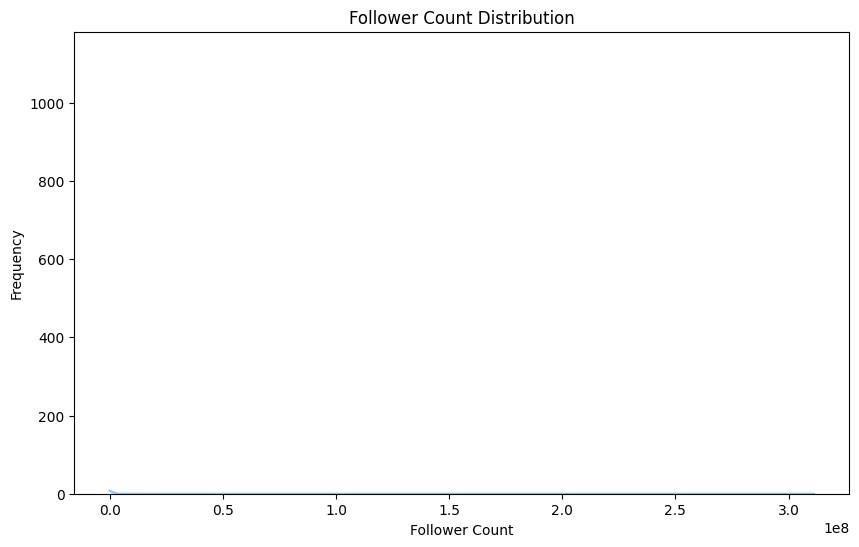

In [11]:
# Follower count distribution

plt.figure(figsize=(10, 6))
sns.histplot(train_profile_df['follower_count'], color='skyblue', kde=True)
plt.title('Follower Count Distribution')
plt.xlabel('Follower Count')
plt.ylabel('Frequency')
plt.show()

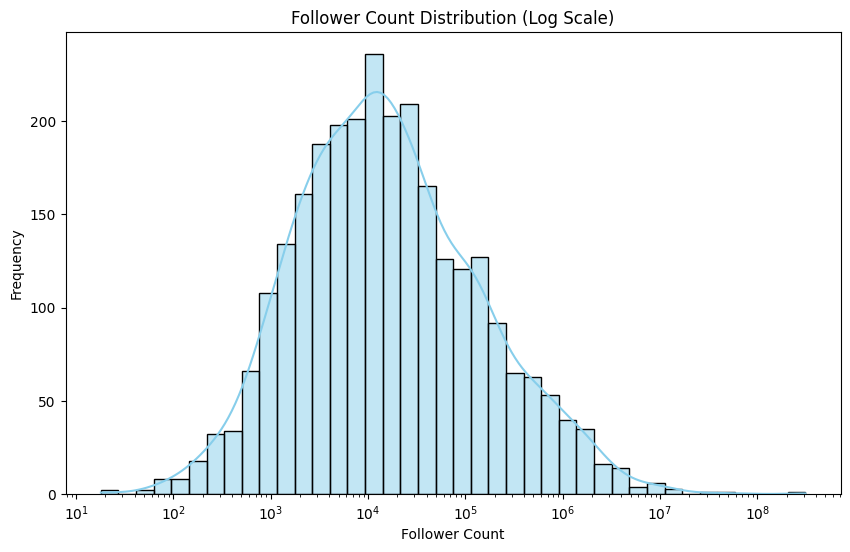

In [12]:
# Follower count distrubution using log scale

plt.figure(figsize=(10, 6))
sns.histplot(train_profile_df['follower_count'], color='skyblue', kde=True, log_scale=True)
plt.title('Follower Count Distribution (Log Scale)')
plt.xlabel('Follower Count')
plt.ylabel('Frequency')
plt.show()

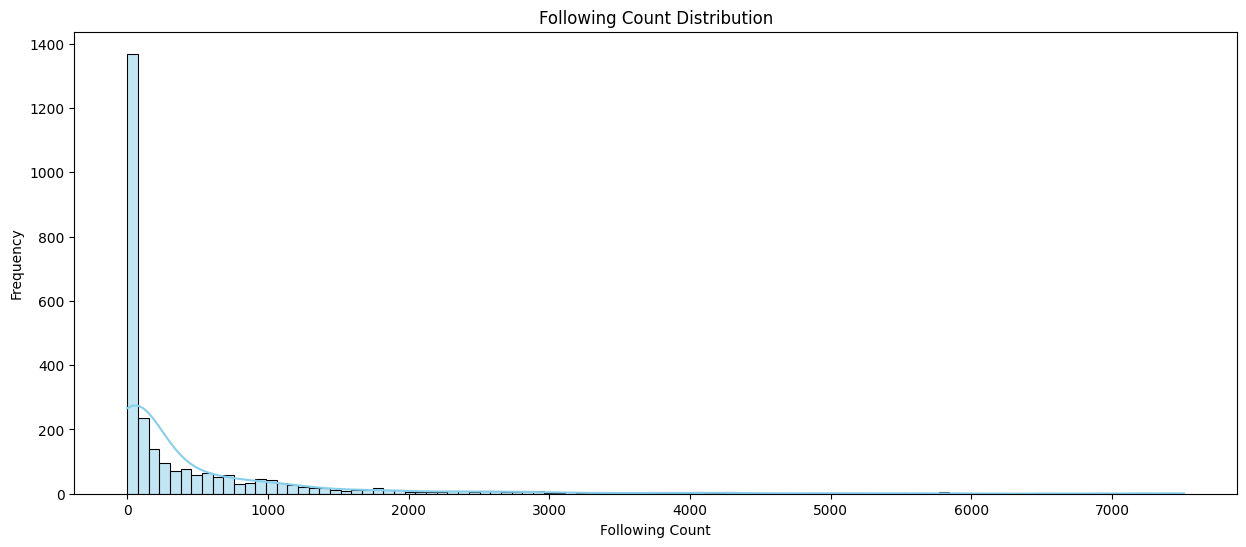

In [13]:
# Plot following count distribution

plt.figure(figsize=(15, 6))
sns.histplot(train_profile_df['following_count'], color='skyblue', kde=True)
plt.title('Following Count Distribution')
plt.xlabel('Following Count')
plt.ylabel('Frequency')
plt.show()

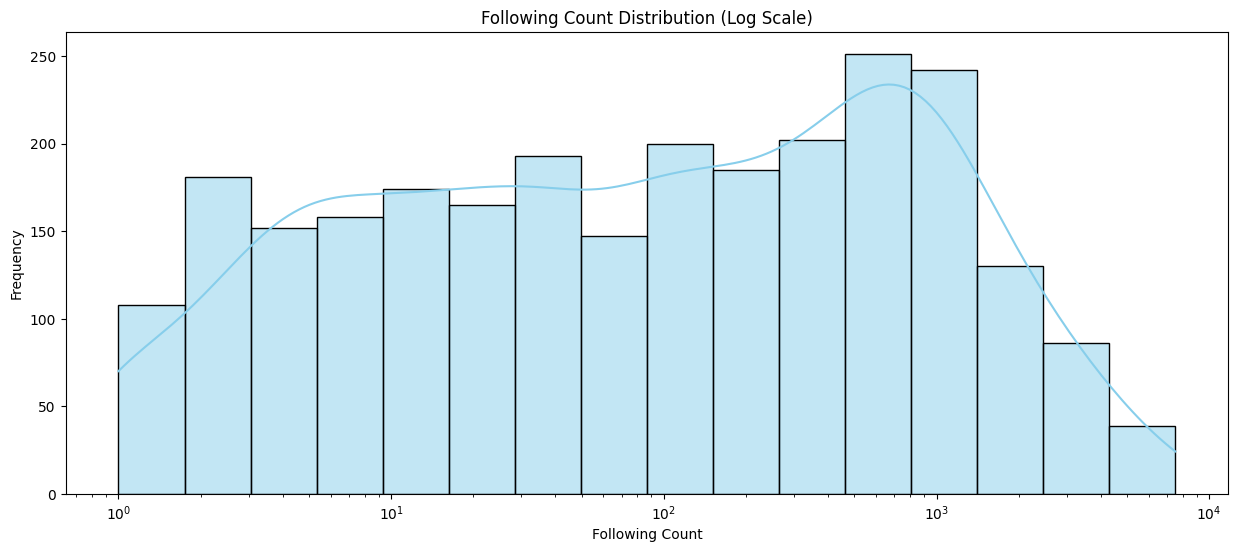

In [14]:
# following count distribution using log scale

# Filter out non-positive values
filtered_following_count = train_profile_df[train_profile_df['following_count'] > 0]['following_count']

plt.figure(figsize=(15, 6))
sns.histplot(filtered_following_count, color='skyblue', kde=True, log_scale=True)
plt.title('Following Count Distribution (Log Scale)')
plt.xlabel('Following Count')
plt.ylabel('Frequency')
plt.show()

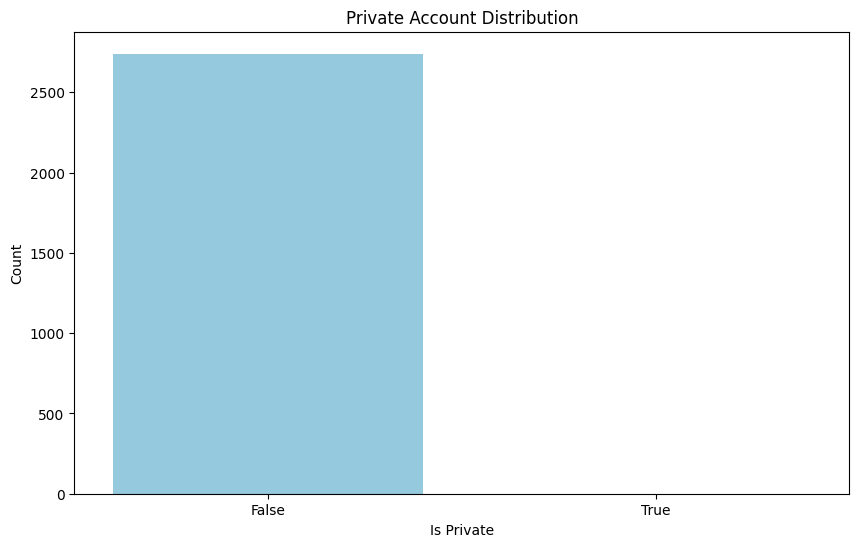

In [15]:
# Private account distribution

plt.figure(figsize=(10, 6))
sns.countplot(data=train_profile_df, x='is_private', color='skyblue')
plt.title('Private Account Distribution')
plt.xlabel('Is Private')
plt.ylabel('Count')
plt.show()

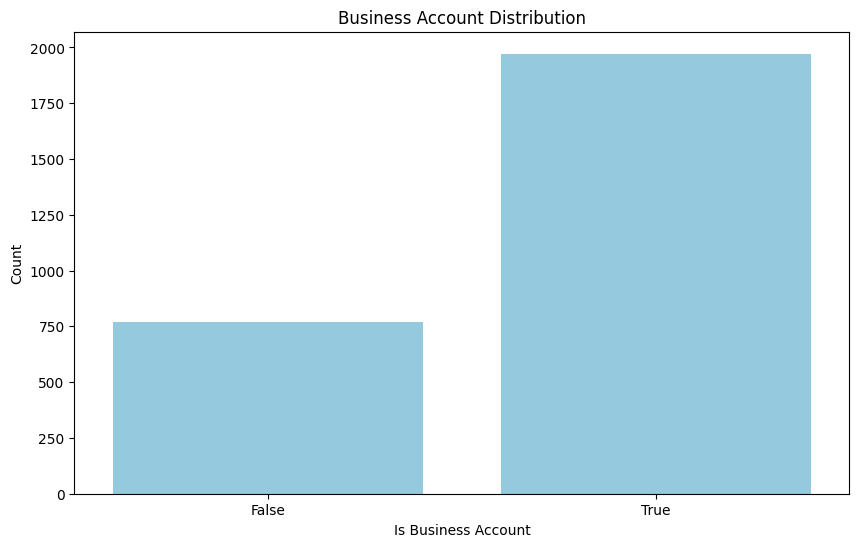

In [16]:
#  Business account distribution

plt.figure(figsize=(10, 6))
sns.countplot(data=train_profile_df, x='is_business_account', color='skyblue')
plt.title('Business Account Distribution')
plt.xlabel('Is Business Account')
plt.ylabel('Count')
plt.show()

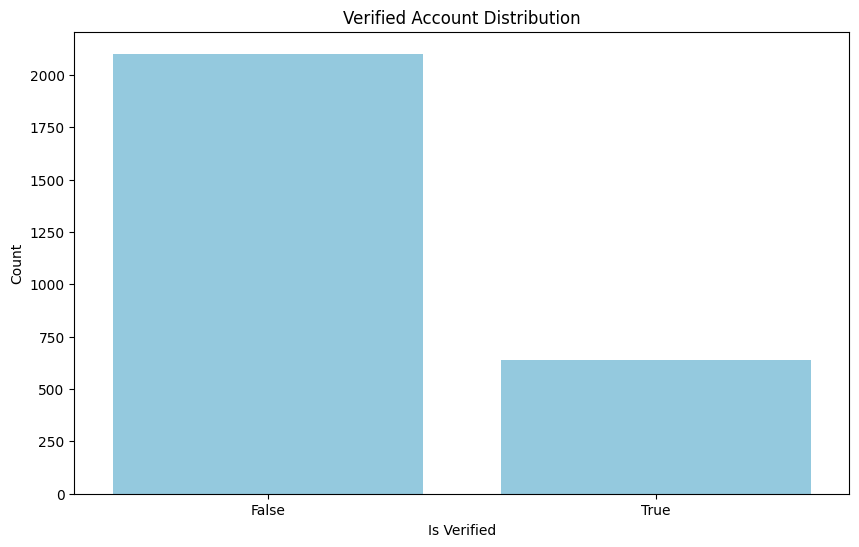

In [17]:
# is verified

plt.figure(figsize=(10, 6))
sns.countplot(data=train_profile_df, x='is_verified', color='skyblue')
plt.title('Verified Account Distribution')
plt.xlabel('Is Verified')
plt.ylabel('Count')
plt.show()

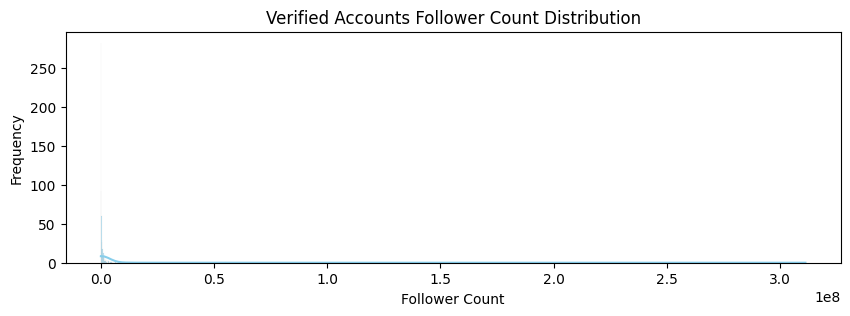

In [18]:
# Verified accounts follower count distribution

plt.figure(figsize=(10, 3))
sns.histplot(train_profile_df[train_profile_df['is_verified'] == True]['follower_count'], color='skyblue', kde=True)
plt.title('Verified Accounts Follower Count Distribution')
plt.xlabel('Follower Count')
plt.ylabel('Frequency')
plt.show()

C:\Users\itsmm\AppData\Local\Temp\ipykernel_3884\1771277240.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_profile_df['follower_count'] = train_profile_df['follower_count'].fillna(0)


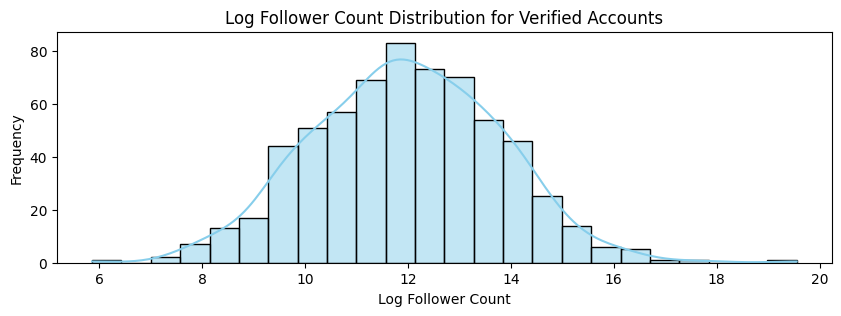

In [19]:
# Log follower count distribution for verified accounts

# Replace None values with 0
train_profile_df['follower_count'] = train_profile_df['follower_count'].fillna(0)

plt.figure(figsize=(10, 3))
sns.histplot(np.log1p(train_profile_df[train_profile_df['is_verified'] == True]['follower_count']), color='skyblue', kde=True)
plt.title('Log Follower Count Distribution for Verified Accounts')
plt.xlabel('Log Follower Count')
plt.ylabel('Frequency')
plt.show()

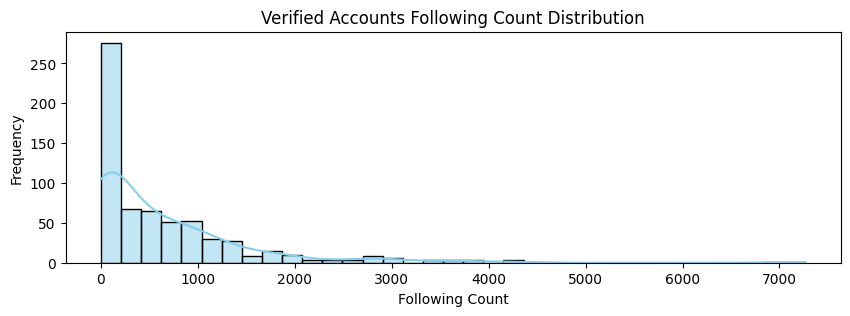

In [20]:
# Verified accounts following count distribution

plt.figure(figsize=(10, 3))
sns.histplot(train_profile_df[train_profile_df['is_verified'] == True]['following_count'], color='skyblue', kde=True)
plt.title('Verified Accounts Following Count Distribution')
plt.xlabel('Following Count')
plt.ylabel('Frequency')
plt.show()


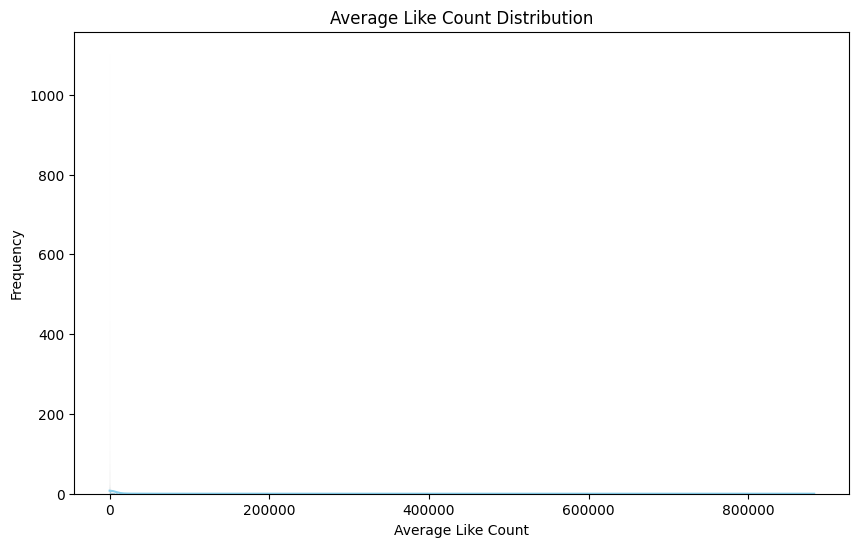

In [21]:
# username2posts_train is a dictionary where the key is a username and the value is a list of posts.
# If like count exists, we are going to get the average per username and plot it.

# Initialize an empty dictionary to store the average like count per username
username2avg_like_count = dict()

# Iterate over the username2posts_train dictionary
for username, posts in username2posts_train.items():
    # Initialize total like count and post count
    total_like_count = 0
    post_count = 0

    # Iterate over the posts
    for post in posts:
        # Get the like count
        like_count = post.get("like_count", 0)

        if like_count is not None:
            # Update total like count and post count
            total_like_count += like_count
            post_count += 1

    # Calculate the average like count
    avg_like_count = total_like_count / post_count if post_count > 0 else 0

    # Store the average like count in the dictionary
    username2avg_like_count[username] = avg_like_count

# Convert the dictionary to a DataFrame
avg_like_count_df = pd.DataFrame(username2avg_like_count.items(), columns=["username", "avg_like_count"])

# Plot the distribution of average like count
plt.figure(figsize=(10, 6))
sns.histplot(avg_like_count_df['avg_like_count'], color='skyblue', kde=True)
plt.title('Average Like Count Distribution')
plt.xlabel('Average Like Count')
plt.ylabel('Frequency')
plt.show()

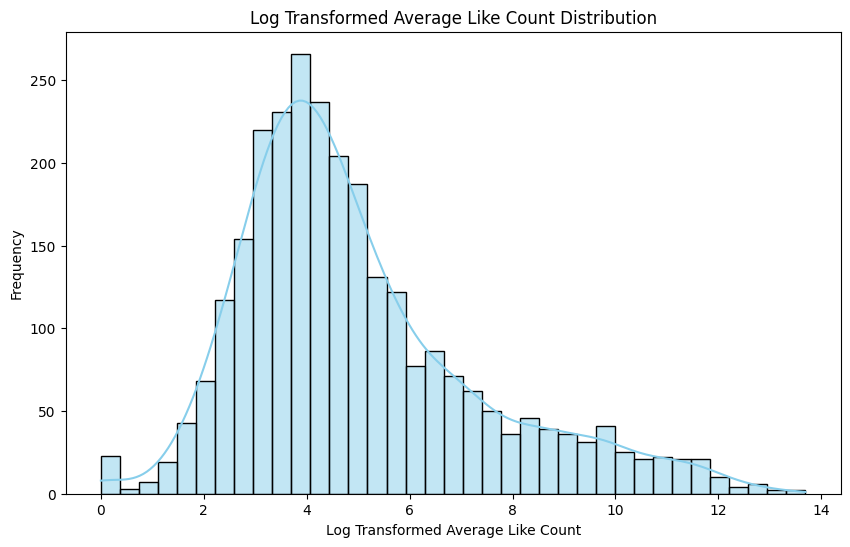

In [22]:
# Apply log transformation to the average like count

# Add a small constant to avoid division by zero
avg_like_count_df['avg_like_count'] = avg_like_count_df['avg_like_count'] + 1

# Apply log transformation
avg_like_count_df['log_avg_like_count'] = np.log(avg_like_count_df['avg_like_count'])

# Plot the distribution of log transformed average like count
plt.figure(figsize=(10, 6))
sns.histplot(avg_like_count_df['log_avg_like_count'], color='skyblue', kde=True)
plt.title('Log Transformed Average Like Count Distribution')
plt.xlabel('Log Transformed Average Like Count')
plt.ylabel('Frequency')
plt.show()

# Classification Model

## Baseline Model

In [23]:
# Text preprocessing

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        # Handle None or non-string inputs
        return ""
    text = text.casefold()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [24]:
corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    cleaned_captions = []
    for post in posts:
        caption = post.get("caption", "")
        if caption is None:
            continue
        cleaned_cap = preprocess_text(caption)
        if cleaned_cap:
            cleaned_captions.append(cleaned_cap)

    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)

# Create y_train labels
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

In [25]:
records = []
for idx, username in enumerate(train_usernames):
    profile = username2profile_train.get(username, {})
    biography_text = str(profile.get("biography", "") or "")
    follower_count = profile.get("follower_count", 0)
    following_count = profile.get("following_count", 0)
    post_count = profile.get("post_count", 0) if profile.get("post_count") else 0

    row_dict = {
        "username": username,
        "captions": corpus[idx],
        "biography": biography_text,
        "follower_count": follower_count,
        "following_count": following_count,
        "post_count": post_count,
        "highlight_reel_count": profile.get("highlight_reel_count", 0),
        "has_clips": profile.get("has_clips", False),
        "is_joined_recently": profile.get("is_joined_recently", False),
        "entities": profile.get("entities", ""),  # could store as text or ignore
        "ai_agent_type": profile.get("ai_agent_type", ""),
        "fb_profile_biolink": profile.get("fb_profile_biolink", ""),
        "restricted_by_viewer": profile.get("restricted_by_viewer", False),
        "country_block": profile.get("country_block", False),
        "eimu_id": profile.get("eimu_id", 0),
        "external_url": profile.get("external_url", ""),
        "fbid": profile.get("fbid", 0),
        "hide_like_and_view_counts": profile.get("hide_like_and_view_counts", False),
        "is_supervision_enabled": profile.get("is_supervision_enabled", False),
        "is_guardian_of_viewer": profile.get("is_guardian_of_viewer", False),
        "is_supervised_by_viewer": profile.get("is_supervised_by_viewer", False),
        "is_supervised_user": profile.get("is_supervised_user", False),
        "is_embeds_disabled": profile.get("is_embeds_disabled", False),
        "business_address_json": profile.get("business_address_json", ""),
        "business_contact_method": profile.get("business_contact_method", ""),
        "business_email": profile.get("business_email", ""),
        "business_phone_number": profile.get("business_phone_number", ""),
        "category_enum": profile.get("category_enum", ""),
        "is_verified_by_mv4b": profile.get("is_verified_by_mv4b", False),
        "is_regulated_c18": profile.get("is_regulated_c18", False),
        "profile_pic_url": profile.get("profile_pic_url", ""),
        "should_show_category": profile.get("should_show_category", False),
        "should_show_public_contacts": profile.get("should_show_public_contacts", False),
        "show_account_transparency_details": profile.get("show_account_transparency_details", False),
        "profile_picture_base64": profile.get("profile_picture_base64", ""),
        "label": y_train[idx]
    }
    records.append(row_dict)

train_full_df = pd.DataFrame(records)


In [26]:
# Split the data into training and validation sets

X = train_full_df.drop(columns=["label"])
y = train_full_df["label"]

x_train_df, x_val_df, y_train_labels, y_val_labels = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [27]:
# ColumnTransformer for text and numerical features

numeric_features = ["follower_count", "following_count", "post_count"]
text_features_caps = "captions"
text_features_bio = "biography"

preprocessor = ColumnTransformer(
    transformers=[
        ("captions_tfidf", TfidfVectorizer(
             stop_words=turkish_stopwords,
             max_features=5000
         ), text_features_caps),
        ("bio_tfidf", TfidfVectorizer(
             stop_words=turkish_stopwords,
             max_features=5000
         ), text_features_bio),
        ("numeric_scaler", MinMaxScaler(), numeric_features)
    ],
    remainder="drop"
)

In [28]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        random_state=42
    ))
])

In [29]:
# Grid search parameters

param_grid = {
    "preprocessor__captions_tfidf__ngram_range": [(1,1), (1,2)],
    "preprocessor__bio_tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train_df, y_train_labels)

print("Best Params:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params: {'clf__C': 10, 'preprocessor__bio_tfidf__ngram_range': (1, 1), 'preprocessor__captions_tfidf__ngram_range': (1, 1)}
Best CV Accuracy: 0.6551037235537732


In [30]:
y_train_pred = best_pipeline.predict(x_train_df)
train_acc = accuracy_score(y_train_labels, y_train_pred)
print("Training Accuracy:", train_acc)
print("\nTraining Classification Report:\n",
      classification_report(y_train_labels, y_train_pred, zero_division=0))

Training Accuracy: 0.9995437956204379

Training Classification Report:
                       precision    recall  f1-score   support

                 art       1.00      1.00      1.00       153
       entertainment       1.00      1.00      1.00       258
             fashion       1.00      1.00      1.00       239
                food       1.00      1.00      1.00       409
              gaming       1.00      1.00      1.00        10
health and lifestyle       1.00      1.00      1.00       402
    mom and children       1.00      1.00      1.00       119
              sports       1.00      1.00      1.00        90
                tech       1.00      1.00      1.00       277
              travel       1.00      1.00      1.00       235

            accuracy                           1.00      2192
           macro avg       1.00      1.00      1.00      2192
        weighted avg       1.00      1.00      1.00      2192



In [31]:
y_val_pred = best_pipeline.predict(x_val_df)
val_acc = accuracy_score(y_val_labels, y_val_pred)
print("Validation Accuracy:", val_acc)
print("\nValidation Classification Report:\n",
      classification_report(y_val_labels, y_val_pred, zero_division=0))

Validation Accuracy: 0.6466302367941712

Validation Classification Report:
                       precision    recall  f1-score   support

                 art       0.24      0.16      0.19        38
       entertainment       0.45      0.34      0.39        65
             fashion       0.51      0.60      0.55        60
                food       0.87      0.89      0.88       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.68      0.75      0.71       100
    mom and children       0.48      0.43      0.46        30
              sports       0.75      0.65      0.70        23
                tech       0.70      0.83      0.76        69
              travel       0.66      0.68      0.67        59

            accuracy                           0.65       549
           macro avg       0.53      0.53      0.53       549
        weighted avg       0.63      0.65      0.63       549



## LightGB

In [32]:
def advanced_text_preprocessing(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    text = text.lower()
    hashtags = re.findall(r'#\w+', text)
    mentions = re.findall(r'@\w+', text)

    text_length = len(text)
    hashtag_density = len(hashtags) / (text_length + 1)
    mention_density = len(mentions) / (text_length + 1)

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    density_info = f" hashtag_density_{hashtag_density:.4f} mention_density_{mention_density:.4f}"
    return f"{text} {' '.join(hashtags)} {' '.join(mentions)} {density_info}".strip()

In [33]:
def build_feature_row(username, profile, posts):
    feats = {}
    follower_count = profile.get("follower_count", 0) or 0
    following_count = profile.get("following_count", 0) or 0
    post_count = profile.get("post_count", 0) or 0

    feats["follower_count"] = follower_count
    feats["following_count"] = following_count
    feats["post_count"] = post_count

    like_counts = [p.get("like_count", 0) or 0 for p in posts]
    feats["avg_like_count"] = np.mean(like_counts) if like_counts else 0
    feats["std_like_count"] = np.std(like_counts) if like_counts else 0

    comment_counts = [p.get("comments_count", 0) or 0 for p in posts]
    feats["avg_comments_count"] = np.mean(comment_counts) if comment_counts else 0
    feats["std_comments_count"] = np.std(comment_counts) if comment_counts else 0

    offset = 1.0
    feats["follower_following_ratio"] = (follower_count + offset) / (following_count + offset)
    feats["like_follower_ratio"] = (feats["avg_like_count"] + offset) / (follower_count + offset)
    feats["comment_follower_ratio"] = (feats["avg_comments_count"] + offset) / (follower_count + offset)

    feats["biography"] = profile.get("biography", "") or ""
    feats["captions"] = "\n".join(post.get("caption", "") or "" for post in posts)

    return feats

In [34]:
def build_train_dataset(username2posts_train, username2profile_train, username2category):
    records = []
    for uname, label in tqdm(username2category.items(), desc="[A] Building training dataset"):
        profile = username2profile_train.get(uname, {})
        posts = username2posts_train.get(uname, [])
        row_dict = build_feature_row(uname, profile, posts)
        row_dict["username"] = uname
        row_dict["label"] = label
        records.append(row_dict)
    return pd.DataFrame(records)

In [35]:
def numeric_feature_engineering(X):
    if isinstance(X, pd.DataFrame):
        df = X.copy()
        for col in ["follower_count", "following_count", "post_count", "avg_like_count", "avg_comments_count"]:
            if col in df.columns:
                df[f"log_{col}"] = np.log1p(df[col].values)
        return df.values
    else:
        return X

In [36]:
def build_final_pipeline(stopwords_list):
    params = {
        "max_features_captions": 8000,
        "max_features_bio": 1500,
        "lgbm_num_leaves": 20,
        "lgbm_max_depth": 15,
        "lgbm_learning_rate": 0.16,
        "lgbm_n_estimators": 300
    }

    numeric_cols = [
        "follower_count", "following_count", "post_count",
        "avg_like_count", "std_like_count",
        "avg_comments_count", "std_comments_count",
        "follower_following_ratio", "like_follower_ratio", "comment_follower_ratio"
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ("captions_tfidf", TfidfVectorizer(
                stop_words=stopwords_list, max_features=params["max_features_captions"],
                ngram_range=(1, 2), min_df=3, max_df=0.95), "captions_clean"),
            ("bio_tfidf", TfidfVectorizer(
                stop_words=stopwords_list, max_features=params["max_features_bio"],
                ngram_range=(1, 1), min_df=3, max_df=0.95), "biography_clean"),
            ("numeric_pipe", Pipeline([
                ("num_feat_eng", FunctionTransformer(numeric_feature_engineering)),
                ("scaler", MinMaxScaler())
            ]), numeric_cols)
        ], remainder="drop"
    )

    lgbm = LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=params["lgbm_num_leaves"],
        max_depth=params["lgbm_max_depth"],
        learning_rate=params["lgbm_learning_rate"],
        n_estimators=params["lgbm_n_estimators"],
        random_state=42,
        verbosity=-1  # Suppresses warnings
    )

    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote_tomek", SMOTETomek(random_state=42)),
        ("classifier", lgbm)
    ])

    return pipeline

In [37]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

    total_steps = 5
    with trange(total_steps, desc="Overall Progress", unit="step") as progress_bar:

        progress_bar.set_description("[A] Building the training dataset...")
        train_df = build_train_dataset(username2posts_train, username2profile_train, username2category)
        progress_bar.update(1)

        progress_bar.set_description("Encoding labels...")
        le = LabelEncoder()
        train_df["label_encoded"] = le.fit_transform(train_df["label"])
        progress_bar.update(1)

        progress_bar.set_description("Cleaning text data...")
        tqdm.pandas(desc="Processing text")
        train_df["captions_clean"] = train_df["captions"].progress_apply(advanced_text_preprocessing)
        train_df["biography_clean"] = train_df["biography"].progress_apply(advanced_text_preprocessing)
        progress_bar.update(1)

        progress_bar.set_description("[B] Training the classification model...")
        X = train_df.drop(columns=["label", "label_encoded", "username"])
        y = train_df["label_encoded"]
        X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        pipeline = build_final_pipeline(stopwords_list=turkish_stopwords)
        pipeline.fit(X_tr, y_tr)
        progress_bar.update(1)

        progress_bar.set_description("[C] Saving model components...")
        y_pred = pipeline.predict(X_val)
        print(f"Validation Accuracy: {accuracy_score(y_val, y_pred) * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

        model_dir = "models"
        os.makedirs(model_dir, exist_ok=True)

        pipeline_path = os.path.join(model_dir, "trained_pipeline.joblib")
        joblib.dump(pipeline, pipeline_path)
        print(f"Pipeline saved at: {pipeline_path}")

        encoder_path = os.path.join(model_dir, "label_encoder.joblib")
        joblib.dump(le, encoder_path)
        print(f"Label encoder saved at: {encoder_path}")

        train_user2label = dict(zip(train_df["username"], train_df["label"]))
        label_mapping_path = os.path.join(model_dir, "training_labels.json")
        with open(label_mapping_path, "w", encoding="utf-8") as f:
            json.dump(train_user2label, f, ensure_ascii=False, indent=4)
        print(f"Label mapping saved at: {label_mapping_path}")

        metadata = {
            "training_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "validation_accuracy": float(accuracy_score(y_val, y_pred)),
            "label_classes": le.classes_.tolist(),
            "model_version": "1.0"
        }
        metadata_path = os.path.join(model_dir, "model_metadata.json")
        with open(metadata_path, "w", encoding="utf-8") as f:
            json.dump(metadata, f, indent=4, ensure_ascii=False)
        print(f"Metadata saved at: {metadata_path}")

        progress_bar.update(1)

    print("Process completed successfully.")

[C] Saving model components...:  80%|████████  | 4/5 [01:18<00:26, 26.77s/step]          

Validation Accuracy: 68.31%
Classification Report:
                      precision    recall  f1-score   support

                 art       0.47      0.37      0.41        38
       entertainment       0.57      0.45      0.50        65
             fashion       0.60      0.70      0.65        60
                food       0.89      0.91      0.90       102
              gaming       0.00      0.00      0.00         2
health and lifestyle       0.60      0.69      0.65       101
    mom and children       0.59      0.57      0.58        30
              sports       0.75      0.65      0.70        23
                tech       0.71      0.80      0.75        69
              travel       0.77      0.68      0.72        59

            accuracy                           0.68       549
           macro avg       0.60      0.58      0.59       549
        weighted avg       0.68      0.68      0.68       549



[C] Saving model components...: 100%|██████████| 5/5 [01:19<00:00, 15.82s/step]

Pipeline saved at: models\trained_pipeline.joblib
Label encoder saved at: models\label_encoder.joblib
Label mapping saved at: models\training_labels.json
Metadata saved at: models\model_metadata.json
Process completed successfully.


In [38]:
def load_test_data():
    """Load and prepare test data"""
    current_notebook_dir = os.getcwd()
    repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))
    data_dir = os.path.join(repo_dir, 'data')
    testing_dir = os.path.join(data_dir, 'testing')
    test_data_path = os.path.join(testing_dir, 'test-classification-round3.dat')

    test_unames = []
    with open(test_data_path, "rt", encoding="utf-8") as fh:
        for line in fh:
            username = line.strip()
            if username != "screenname":
                test_unames.append(username)

    return test_unames, data_dir

def prepare_test_features(test_unames, username2posts_test, username2profile_test):
    """Prepare features for test data"""
    test_records = []
    for username in tqdm(test_unames, desc="Preparing test features"):
        posts = username2posts_test.get(username, [])
        profile = username2profile_test.get(username, {})

        row_dict = build_feature_row(username, profile, posts)
        row_dict["username"] = username
        test_records.append(row_dict)

    return pd.DataFrame(test_records)

In [39]:
def predict_with_username_lookup(df, pipeline, train_user2label, label_encoder):
    """
    Make predictions using training data labels when available,
    otherwise use the model pipeline.
    """
    known_mask = df["username"].isin(train_user2label)

    # Process predictions
    df_unknown = df[~known_mask].copy()
    X_unknown = df_unknown.drop(columns=["username"])
    numeric_predictions = pipeline.predict(X_unknown)
    category_predictions = label_encoder.inverse_transform(numeric_predictions)

    # Combine predictions
    y_pred_final = []
    j = 0
    for idx in df.index:
        if known_mask.loc[idx]:
            user = df.loc[idx, "username"]
            y_pred_final.append(train_user2label[user])
        else:
            y_pred_final.append(category_predictions[j])
            j += 1

    # Analysis summary
    final_categories = pd.Series(y_pred_final).value_counts()
    total_accounts = len(df)

    print("\nInfluencer Category Classification Analysis")
    print("-" * 50)
    print(f"Total Accounts: {total_accounts:,}")
    print(f"Training Data Matches: {known_mask.sum():,}")
    print(f"Model Predictions: {(~known_mask).sum():,}")

    print("\nCategory Distribution:")
    print("-" * 50)
    for category, count in final_categories.items():
        percentage = (count / total_accounts) * 100
        print(f"{category:<20} {percentage:>5.1f}% ({count:,})")

    return np.array(y_pred_final)

def save_predictions(predictions, usernames, output_dir):
    """Save predictions to JSON file"""
    os.makedirs(output_dir, exist_ok=True)
    output = dict(zip(usernames, predictions))
    output_path = os.path.join(output_dir, 'prediction-classification-round3.json')

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(output, f, indent=4)

    print(f"\nResults exported to: {output_path}")

def main():
    # Load data and model components
    test_unames, data_dir = load_test_data()
    model_dir = os.path.join(data_dir, 'models')

    try:
        pipeline = joblib.load(os.path.join(model_dir, 'trained_pipeline.joblib'))
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.joblib'))
        with open(os.path.join(model_dir, 'training_labels.json'), 'r', encoding='utf-8') as f:
            train_user2label = json.load(f)
    except FileNotFoundError as e:
        print("Error: Required model components not found.")
        raise e

    # Process test data
    x_test_df = prepare_test_features(test_unames, username2posts_test, username2profile_test)
    x_test_df['captions_clean'] = x_test_df['captions'].progress_apply(advanced_text_preprocessing)
    x_test_df['biography_clean'] = x_test_df['biography'].progress_apply(advanced_text_preprocessing)

    # Generate and save predictions
    predictions = predict_with_username_lookup(x_test_df, pipeline, train_user2label, label_encoder)
    save_predictions(predictions.tolist(), test_unames, os.path.join(data_dir, 'output'))

if __name__ == "__main__":
    main()

Processing text: 100%|██████████| 1000/1000 [00:00<00:00, 110740.70it/s]



Influencer Category Classification Analysis
--------------------------------------------------
Total Accounts: 1,000
Training Data Matches: 266
Model Predictions: 734

Category Distribution:
--------------------------------------------------
health and lifestyle  26.0% (260)
food                  14.1% (141)
tech                  13.8% (138)
entertainment         13.2% (132)
fashion               10.5% (105)
travel                 8.8% (88)
art                    7.6% (76)
sports                 3.0% (30)
mom and children       2.8% (28)
gaming                 0.2% (2)

Results exported to: c:\Users\itsmm\OneDrive\Desktop\CS412\CS412-InstagramInfluencersAnalysis\data\output\prediction-classification-round3.json


# Regression Model

In [40]:
# Global Configuration
RECENT_BETTER_THRESHOLD = 1.12
RECENT_WORSE_THRESHOLD = 0.85
RECENT_BETTER_MULTIPLIER = 1.08
RECENT_WORSE_MULTIPLIER = 0.92
MIN_TOTAL_POSTS = 4
RECENT_POSTS_TO_CHECK = 7
SMOOTHING_OFFSET = 3

In [41]:
def parse_timestamp(ts_string):
    try:
        return datetime.strptime(ts_string, '%Y-%m-%d %H:%M:%S')
    except:
        return None

In [42]:
def predict_like_count(username, current_post=None):
    def get_avg_like_count(posts: list):
        total = 0.0
        count = 0
        for post in posts:
            if current_post is not None and post.get("id") == current_post.get("id"):
                continue
            like_count = post.get("like_count", 0) or 0
            total += like_count
            count += 1

        return (total + SMOOTHING_OFFSET) / (count + SMOOTHING_OFFSET)

    if username in username2posts_train:
        return get_avg_like_count(username2posts_train[username])
    elif username in username2posts_test:
        return get_avg_like_count(username2posts_test[username])
    else:
        print(f"No data available for {username}, returning -1.")
        return -1

In [43]:
def extract_features_for_post(username, post, user_last_post_time, train_data=None):
    feats = {}

    # Base prediction with smoothing
    base_pred = predict_like_count(username, current_post=post)
    feats['base_pred'] = base_pred
    feats['log_base_pred'] = np.log1p(base_pred)

    # Time features
    ts = parse_timestamp(post.get('timestamp', '0000-00-00 00:00:00'))
    if ts:
        hour = ts.hour
        day_of_week = ts.weekday()
        feats['hour'] = hour
        feats['day_of_week'] = day_of_week
        feats['is_weekend'] = 1 if day_of_week >= 5 else 0

        # Time periods
        peak_hours = {18, 19, 20, 21, 12, 13, 17}
        feats['is_peak_hour'] = 1 if hour in peak_hours else 0
        feats['is_morning'] = 1 if 6 <= hour < 11 else 0
        feats['is_afternoon'] = 1 if 11 <= hour < 17 else 0
        feats['is_evening'] = 1 if 17 <= hour < 22 else 0
        feats['is_night'] = 1 if hour >= 22 or hour < 6 else 0
    else:
        feats.update({
            'hour': 0, 'day_of_week': 0, 'is_weekend': 0,
            'is_peak_hour': 0, 'is_morning': 0, 'is_afternoon': 0,
            'is_evening': 0, 'is_night': 0
        })

    # Time since last post
    if user_last_post_time.get(username) is not None:
        prev_ts = user_last_post_time[username]
        delta = (ts - prev_ts).total_seconds()/3600.0 if (ts and prev_ts) else 0
        feats['time_since_last_post_hrs'] = max(delta, 0)
    else:
        feats['time_since_last_post_hrs'] = 0

    if ts:
        user_last_post_time[username] = ts

    # Engagement metrics
    comments_count = post.get('comments_count', 0) or 0
    feats['comments_count'] = comments_count
    feats['log_comments'] = np.log1p(comments_count)

    # Performance analysis using training data
    posts_to_analyze = train_data.get(username, []) if train_data else []

    if len(posts_to_analyze) >= MIN_TOTAL_POSTS:
        # Recent performance
        sorted_posts = sorted(posts_to_analyze,
                            key=lambda x: x.get('timestamp', ''),
                            reverse=True)
        recent_posts = sorted_posts[:RECENT_POSTS_TO_CHECK]
        recent_likes = [p.get('like_count', 0) or 0 for p in recent_posts]

        if recent_likes:
            recent_avg = np.mean(recent_likes)
            recent_std = np.std(recent_likes) if len(recent_likes) > 1 else 0
            feats['recent_ratio'] = recent_avg / max(base_pred, 1)
            feats['recent_volatility'] = recent_std / max(recent_avg, 1)
        else:
            feats['recent_ratio'] = 1.0
            feats['recent_volatility'] = 0.0

        # Media type performance
        media_type = post.get('media_type', 'PHOTO')
        media_likes = {}
        for p in posts_to_analyze:
            mt = p.get('media_type', 'PHOTO')
            lk = p.get('like_count', 0) or 0
            media_likes.setdefault(mt, []).append(lk)

        if media_type in media_likes and media_likes[media_type]:
            type_avg = np.mean(media_likes[media_type])
            all_likes = [l for likes in media_likes.values() for l in likes]
            overall_avg = np.mean(all_likes) if all_likes else 1.0
            feats['media_ratio'] = type_avg / max(overall_avg, 1.0)
        else:
            feats['media_ratio'] = 1.0
    else:
        feats.update({
            'recent_ratio': 1.0,
            'recent_volatility': 0.0,
            'media_ratio': 1.0
        })

    return feats

In [44]:
def build_dataset_for_regression(username2posts, train_data=None):
    records = []
    user_last_post_time = {}

    for uname, posts in tqdm(username2posts.items(), desc="Building dataset"):
        user_posts_sorted = sorted(posts, key=lambda x: x.get('timestamp', ''))
        for post in user_posts_sorted:
            row_feats = extract_features_for_post(
                uname, post, user_last_post_time, train_data
            )
            like_count = post.get('like_count', 0) or 0
            row_feats['target_log_likes'] = np.log10(like_count + 1)
            row_feats['username'] = uname
            row_feats['post_id'] = post.get('id', '')
            records.append(row_feats)

    df = pd.DataFrame(records)
    y = df.pop('target_log_likes').values
    return df, y

In [45]:
def manual_xgb_grid_search(X, y, param_grid, cv=3, random_state=42):
    from itertools import product
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    param_names = list(param_grid.keys())
    all_combos = list(product(*param_grid.values()))

    best_mse = float('inf')
    best_params = None
    all_results = []

    with tqdm(total=len(all_combos), desc="Grid Search") as pbar:
        for combo in all_combos:
            curr_params = dict(zip(param_names, combo))
            xgb_model = XGBRegressor(
                n_estimators=curr_params['n_estimators'],
                max_depth=curr_params['max_depth'],
                learning_rate=curr_params['learning_rate'],
                subsample=curr_params['subsample'],
                random_state=random_state,
                n_jobs=-1
            )

            kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
            fold_mses = []

            for train_idx, val_idx in kf.split(X):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]

                xgb_model.fit(X_train_fold, y_train_fold)
                y_val_pred = xgb_model.predict(X_val_fold)
                fold_mses.append(np.mean((y_val_fold - y_val_pred)**2))

            mean_fold_mse = np.mean(fold_mses)
            result_dict = curr_params.copy()
            result_dict['mean_cv_mse_log'] = mean_fold_mse
            all_results.append(result_dict)

            if mean_fold_mse < best_mse:
                best_mse = mean_fold_mse
                best_params = curr_params.copy()

            pbar.update(1)

    best_model = XGBRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        random_state=random_state,
        n_jobs=-1
    )
    best_model.fit(X, y)

    return best_model, best_params, all_results

In [46]:
if __name__ == "__main__":
    # Build training dataset
    print("\nBuilding train dataset...")
    X_train_df, y_train = build_dataset_for_regression(username2posts_train)

    # Simplified parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }

    # Prepare training data
    X_train_drop = X_train_df.drop(columns=['username', 'post_id'], errors='ignore')
    X_train_vals = X_train_drop.values.astype(float)

    # Train model
    best_model, best_params, all_results = manual_xgb_grid_search(
        X_train_vals,
        y_train,
        param_grid=param_grid,
        cv=3,
        random_state=42
    )

    # Evaluate on training set
    train_preds = best_model.predict(X_train_vals)
    train_mse = np.mean((y_train - train_preds) ** 2)
    print(f"Train MSE in log-space = {train_mse:.4f}")

    # Build and evaluate on validation dataset
    print("\nBuilding validation dataset...")
    X_val_df, y_val = build_dataset_for_regression(
        username2posts_test,
        train_data=username2posts_train
    )

    X_val = X_val_df.drop(columns=['username', 'post_id'], errors='ignore').values
    y_val_pred = best_model.predict(X_val)
    val_mse = np.mean((y_val - y_val_pred) ** 2)
    print(f"Validation Log MSE = {val_mse:.4f}")


Building train dataset...


Grid Search: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


Train MSE in log-space = 0.1388

Building validation dataset...


Building dataset: 100%|██████████| 2674/2674 [00:01<00:00, 1823.91it/s]


Validation Log MSE = 0.1359


In [47]:
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the testing directory
testing_dir = os.path.join(data_dir, 'testing')

# Path to your test .jsonl file
test_dataset_path = os.path.join(testing_dir, 'test-regression-round3.jsonl')

# Output directory + file
output_dir = os.path.join(data_dir, 'output')
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, 'prediction-regression-round3.json')

In [48]:
username2posts_inference = {}

with open(test_dataset_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        sample = json.loads(line)
        uname = sample["username"]
        # Collect posts in a dict => { username: [ posts... ] }
        if uname not in username2posts_inference:
            username2posts_inference[uname] = []
        username2posts_inference[uname].append(sample)

In [49]:
# Inference Dataframe
X_inf_df, _ = build_dataset_for_regression(username2posts_inference)

Building dataset: 100%|██████████| 3000/3000 [00:00<00:00, 42840.84it/s]


In [50]:
y_pred_likes = best_model.predict(X_inf_df.drop(columns=['username', 'post_id'], errors='ignore').values)
y_pred_likes = np.expm1(y_pred_likes)

In [51]:
predicted_dict = {}
for i, row in X_inf_df.iterrows():
    post_id = row['post_id']
    predicted_dict[post_id] = int(round(y_pred_likes[i]))  # Convert to integer predictions

In [52]:
output_list = []

for uname, posts in username2posts_inference.items():
    for post in posts:
        pid = post['id']
        pred_val = predicted_dict.get(pid, 0)  # fallback if missing
        output_dict = {
            'id': pid,
            'like_count': pred_val,
            'username': post['username'],
            'media_type': post.get('media_type', ''),
            'comments_count': post.get('comments_count', 0),
            'timestamp': post.get('timestamp', ''),
            'media_url': post.get('media_url', None)
        }
        output_list.append(output_dict)

In [53]:
predictions_dict = {item['id']: item['like_count'] for item in output_list}

with open(output_file_path, "wt", encoding="utf-8") as of:
    json.dump(predictions_dict, of, indent=4)

print(f"\nProcessed data saved to: {output_file_path}")
print("\nFirst 5 predictions:")
for k in list(predictions_dict.keys())[:5]:
    print(k, "=>", predictions_dict[k])


Processed data saved to: c:\Users\itsmm\OneDrive\Desktop\CS412\CS412-InstagramInfluencersAnalysis\data\output\prediction-regression-round3.json

First 5 predictions:
18299464882193238 => 18
17870639199008459 => 9
17976060503438195 => 28
17980348256173250 => 94
18030944311530609 => 5
